# Show plots

In [137]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from pathlib import Path
from IPython.display import display
import pickle
# from env_utils import read_pso_search_files, detect_convergence
%matplotlib inline

## Read file

In [138]:
# Replace with the path of the output file on your local machine
# output_path_base = Path("../../output/cutin_one/ba/03032350_0.7_20x50_0/front_cut_in_with_one_npc")
# output_path_base = Path("../../output/cutin_one/ba/03042329_0.5_20x50_0/front_cut_in_with_one_npc")
output_path_base = Path("../../output/nonsignalized_junction_left_turn/ba/04041410_0.7_20x50_0")
# output_path_base = Path("../../output/cutin_one/if/03021645_0.3_20x50_0/front_cut_in_with_one_npc")
# output_path_base = Path("../../output/nonsignalized_junction_left_turn/apollo/03300842_0.0_20x50_0")

# read pickle file
with open(output_path_base / "logbook.pkl", "rb") as f:
    logbook = pickle.load(f)
with open(output_path_base / "species.pkl", "rb") as f:
    species = pickle.load(f)

search_df = search_df = pd.read_csv(f"{output_path_base}/search_spso.csv")

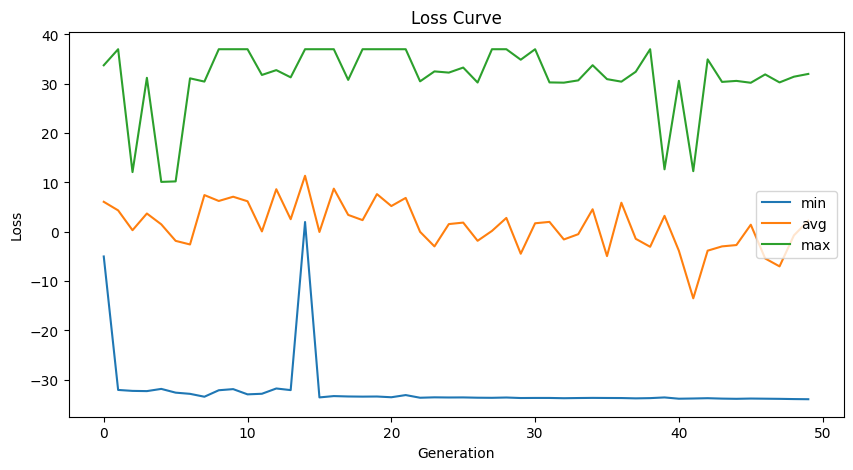

In [139]:
gen = logbook.select("gen")
loss_min = logbook.select("min")
loss_avg = logbook.select("avg")
loss_max = logbook.select("max")

# draw the loss curve
plt.figure(figsize=(10, 5))
plt.plot(gen, loss_min, label="min")
plt.plot(gen, loss_avg, label="avg")
plt.plot(gen, loss_max, label="max")
plt.xlabel("Generation")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()


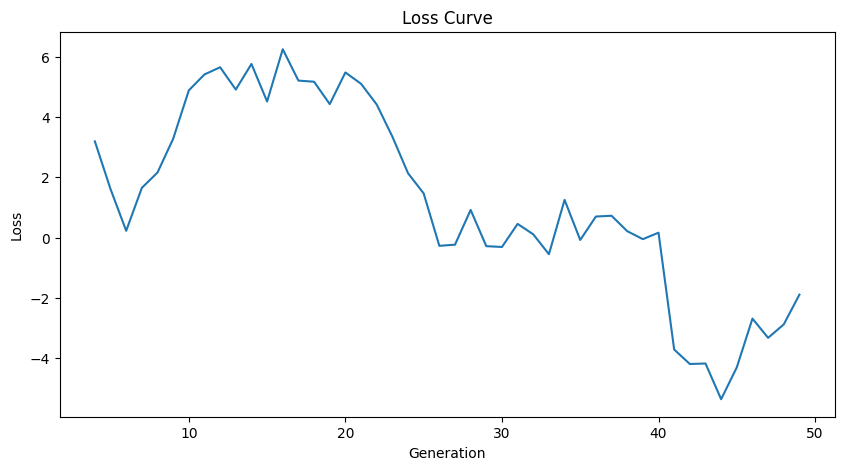

In [140]:
# draw loss_avg, need to smooth it first
loss_avg_smooth = pd.Series(loss_avg).rolling(window=5).mean()
plt.figure(figsize=(10, 5))
plt.plot(gen, loss_avg_smooth, label="avg")
plt.xlabel("Generation")
plt.ylabel("Loss")
plt.title("Loss Curve")
# plt.legend()
plt.show()

In [141]:
for s in species:
    if len(s) == 1:
        average = s[0].bestfit.values[0]
    else:
        average = sum(p.bestfit.values[0] for p in s if p.best is not None) / len(s)
    print(s[0].bestfit.values[0], s[0].best, len(s), average)

-33.929376745224 [15.688400879613159, 2.004954233966588, 46.67905225363838, 11.399899765581315] 13 -25.934745265887337
4.061088615417481 [67.6014164162745, 8.31310594889407, 62.40273756984917, 13.269104585367748] 6 9.558381649017335
5.831208904266358 [12.227080568183101, 16.1600375217392, 58.347763788444084, 20.395342194459438] 1 5.831208904266358


In [142]:
# drop duplicates
search_df_unique = search_df.drop_duplicates(subset=search_df.columns[7:], keep='first')
search_df_last20 = search_df_unique.tail(20)
# search_df_last20

In [143]:
this_df = search_df_unique.copy()

import ast

# get collision_status column from search_df, where ttc=0
collision_status = this_df['collision_status']

collision_status_list = []

# parse each collision_status string into a dictionary
for status in collision_status:
    dict_obj = ast.literal_eval(status)
    if len(dict_obj['EGO']) == 0:
        continue
    collision_status_list.append(dict_obj)

print(len(collision_status_list))



191


In [144]:
import math

def collision_type(x_ego, y_ego, v_ego, yaw_ego, x_npc, y_npc, v_npc, yaw_npc):
    # Calculate the relative position angle
    rel_angle = math.atan2(y_npc - y_ego, x_npc - x_ego)
    
    # Convert angles from radians to degrees for easier comparison
    rel_angle = abs(math.degrees(rel_angle))
    yaw_ego_deg = yaw_ego
    yaw_npc_deg = yaw_npc
    rel_yaw = abs(yaw_npc_deg - yaw_ego_deg)

    # print(f"rel_angle: {rel_angle}, rel_yaw: {rel_yaw}")
    
    # T-Bone collision
    if 80 <= rel_yaw <= 100:
        return "T-Bone"
    
    # Merge collision
    if 0 < rel_yaw < 80 and 70 <= rel_angle <= 110:
        return "Merge"
    
    # Head On collision
    if 170 <= rel_yaw <= 180:
        return "Head On"
    
    # Front collision
    if 100 <= rel_yaw <= 170:
        return "Front"
    
    # Cutoff collision
    if 0 <= rel_yaw < 80 and 0 <= rel_angle < 70:
        return "Cutoff"
    
    # Behind collision
    if 0 <= rel_yaw < 10 and 170 <= rel_angle < 180:
        return "Behind"
    
    # If none of the conditions are met, return "Unknown"
    return None

In [145]:
collision_type_list = []

for collision_status in collision_status_list:
    ego = collision_status['EGO']
    npc = collision_status['NPC']
    
    x_ego, y_ego, v_ego, yaw_ego = ego
    x_npc, y_npc, v_npc, yaw_npc = npc

    col_type = collision_type(x_ego, y_ego, v_ego, yaw_ego, x_npc, y_npc, v_npc, yaw_npc)

    collision_type_list.append(col_type)
    # print(col_type)
    
    # print(f"Collision type: {col_type} | EGO: ({x_ego}, {y_ego}, {v_ego}, {yaw_ego}) | NPC: ({x_npc}, {y_npc}, {v_npc}, {yaw_npc})")

# show distribution of collision types
# sns.histplot(collision_type_list)
# plt.title("Collision Type Distribution")
# plt.show()

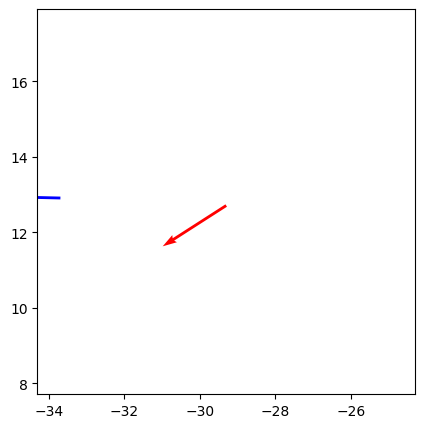

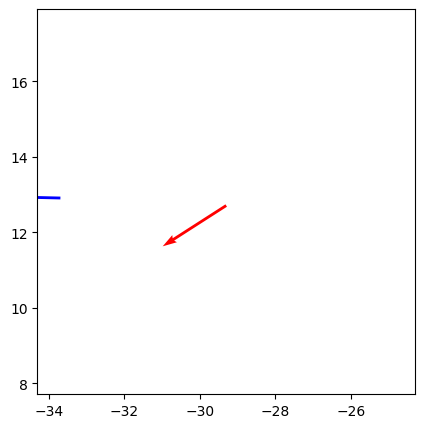

In [146]:
# draw the location and direction of EGO and NPC for each collision
for collision_status in collision_status_list[:2]:
    collision_status = {'EGO': [-33.697513580322266, 12.911392211914062, 0.14116022165388684, 178.6713104248047], 'NPC': [-29.304887771606445, 12.712081909179688, 0.13009506743689966, -147.2995147705078]}
    ego = collision_status['EGO']
    npc = collision_status['NPC']
    
    x_ego, y_ego, v_ego, yaw_ego = ego
    x_npc, y_npc, v_npc, yaw_npc = npc
    
    plt.figure(figsize=(5, 5))
    plt.xlim(min(x_npc, x_npc)-5, max(x_npc, x_npc)+5)
    plt.ylim(min(y_ego, y_npc)-5, max(y_ego, y_npc)+5)
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.quiver(x_ego, y_ego, math.cos(math.radians(yaw_ego)), math.sin(math.radians(yaw_ego)), color='blue', scale=5)
    plt.quiver(x_npc, y_npc, math.cos(math.radians(yaw_npc)), math.sin(math.radians(yaw_npc)), color='red', scale=5)
    
    plt.show()